In [28]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from helpers import *

In [29]:
# path to project directory
path = Path('./')

In [30]:
# read in training dataset
train_df = pd.read_csv(path/'data/train_v7.csv', index_col=0, dtype={'season':str,
                                                                     'squad':str,
                                                                     'comp':str})

## Baseline model

A baseline model is an effective way to see whether more sophisticated approaches actually have more predictive power. You may be able to impress your friends by using a fabulously sophisticated and exotic sounding algorithm, but if it's unable to beat a straightforward approach then it's no use to us whatsoever.

We will do the following: a player's predicted score is simply the points scored per minute for every minute played in history, multiplied by the actual number of minutes played in the gameweek being predicted (note that, at the moment, the predicted number of minutes is not included in the model).

We'll start by using the lag_features functions to obtain the points per game (90 minutes) for all games in history at each gameweek for each player (including team and opponent team points per game).

In [31]:
# add all lag points scored to training set
train_df, team_lag_vars = team_lag_features(train_df, ['total_points'], ['all'])
train_df, player_lag_vars = player_lag_features(train_df, ['total_points'], ['all'])

Lets check it looks sensible for one of the players.

In [32]:
train_df[['gw', 'total_points_last_all', 'total_points_team_last_all']][train_df['player'] == 'Kevin_De Bruyne'].tail()

,gw,total_points_last_all,total_points_team_last_all


Our baseline model function generates predictions using the above approach for a given validation point (i.e. which gameweek the validation starts) and validation length (how many gameweeks will we include, from the validation point). If a player has no history then we just assume that they will have the league average points per game (3.74).

We return the predictions and actuals to allow easy performance assessment. If a row shows 0 minutes for a player, we know that they will have scored 0 points, so we will exclude these from our predictions.

In [33]:
def simple_model(df, valid_season, valid_gw, valid_len):
    # get our validation index points
    valid_start, valid_end = validation_gw_idx(df, valid_season, valid_gw, valid_len)
    
    # indexes for training and validation sets
    train_idx = range(valid_start)
    valid_idx = range(valid_start, valid_end + 1)    
    
    # create training and validation dataframes
    # the validation set has no features
    train = df.iloc[train_idx]
    valid = df[['player', 'gw', 'season', 'minutes', 'total_points']].iloc[valid_idx]
    
    season_point = valid['season'].iloc[0]
    gw_point = valid['gw'].iloc[0]
    
    # get player total per game average at validation point
    player_points_pg = df[(df['season'] == season_point) & 
                          (df['gw'] == gw_point)][['player', 'total_points_pg_last_all']]
    
    # sometimes players play twice in a gw, we want the values at the first game
    player_points_pg =  player_points_pg.groupby('player').first().reset_index()
    
    # set the player per game averages for all games in the validation set 
    pred_df = valid.merge(player_points_pg, on='player', how='left')
    
    # we only want to see performance for rows with minutes>0
    pred_df = pred_df[pred_df['minutes'] > 0]
    
    # use the average across all players-minutes for any nulls (from 00_fpl_features) 
    # i.e. where player does not have any history
    pred_df.fillna(3.74, inplace=True)
    preds = pred_df['total_points_pg_last_all'] * pred_df['minutes'] / 90
    targs = pred_df['total_points']
    
    return preds, targs

We can ahead and use this model to make some predictions for a single gameweek.

In [34]:
# set validation start at gameweek 20 in the 2019/20 season
# validate 6 gameweek's of predictions
valid_season = '1920'
valid_gw = 20
valid_len = 6

# make predictions
preds, targs = simple_model(train_df, valid_season, valid_gw, valid_len)

And calculate a couple of error metrics for these predictions: the root mean squared error and mean absolute error.

In [35]:
# rmse for predictions versus actuals
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)

# mse for predictions versus actuals
def mae(pred, y):  return round(abs(pred-y).mean(), 6)

In [36]:
# calculate rsme
r_mse(preds, targs)

2.805876

In [37]:
# calculate mae
mae(preds, targs)

2.051663

It's worth running little tests to check for errors. In this case we can perform the same prediction using a slightly more direct way (not using any indexes).

In [38]:
# we can calculate the same predictions directly using the season and gameweek
# to check the above function 
# get player total per game average at validation point
player_points_pg = train_df[(train_df['season'] == '1920') & 
                            (train_df['gw'] == valid_gw)][['player', 'total_points_pg_last_all']]

player_points_pg =  player_points_pg.groupby('player').first().reset_index()

valid_df = train_df[(train_df['season'] == '1920') 
                    & (train_df['gw'] > valid_gw - 1)
                    & (train_df['gw'] < valid_gw + 6)][['player', 'minutes', 'total_points']]

pred_df = valid_df.merge(player_points_pg, on='player', how='left')
pred_df = pred_df[pred_df['minutes'] > 0]
pred_df.fillna(3.74, inplace=True)
pred_df['pred'] = pred_df['total_points_pg_last_all'] * pred_df['minutes'] / 90
pred_df.fillna(0, inplace=True)

In [39]:
# calculate rmse
r_mse(pred_df['pred'], pred_df['total_points'])

2.805876

The two error values should equal. The intention is to introduce more of these tests in a more robust software engineering way (i.e. unit tests) in the future.

Now let's apply this method across the entire 2019/20 season and chart the result.

In [40]:
def simple_model_season(df, valid_season='1920'):
    # empty list for scores
    scores = []
    valid_len = 6
    
    for valid_gw in range(1,40-valid_len):
        preds, targs = simple_model(df, valid_season, valid_gw, valid_len)
        scores.append(mae(preds, targs))
        
    return scores      

In [41]:
scores = simple_model_season(train_df)

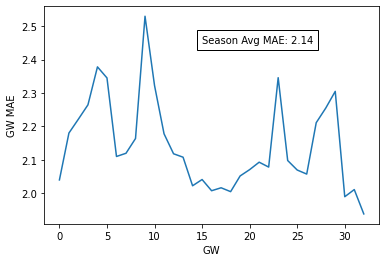

In [42]:
plt.plot(scores)
plt.ylabel('GW MAE')
plt.xlabel('GW')
plt.text(15, 2.45, 'Season Avg MAE: %.2f' % np.mean(scores), bbox={'facecolor':'white', 'alpha':1, 'pad':5})
plt.show()

The performance of the simple model varies from week to week, but looks to be improving over the season. Lets put these scores in a csv file that we can later use to create a comparison chart for all our modelling approaches.

In [43]:
# create score dataframe and save to csv
# model_validation_scores = pd.DataFrame(scores, columns=['baseline'])
# model_validation_scores.index = range(1,len(scores)+1)
model_validation_scores = pd.read_csv(path/'charts/model_validation_scores.csv', index_col=0)
model_validation_scores['baseline'] = scores
model_validation_scores.to_csv(path/'charts/model_validation_scores.csv')

In [44]:
# quick check it saved ok
pd.read_csv(path/'charts/model_validation_scores.csv', index_col=0).head()

,baseline,random_forest,xgboost,neural_net
1,2.039775,2.027455,1.877270,1.956985
2,2.180048,2.031769,1.872789,1.869431
3,2.221809,2.014071,1.927256,1.993806
4,2.264458,1.939277,1.857652,1.908115
5,2.378001,1.993267,1.915295,1.952784


So now we have a baseline we can move onto the first modelling approach, but first we need to take some care with our validation data.

## Validation set preparation

In the above model we use the lag points per game values from the first validation gameweek, since these contain information for everything up to but not including the validation gameweek. However, these lag variables are calculated for each gameweek, so it is important not to use them for predictions being made more than 1 gameweek after the validation point. The above model gives us a useful way to create a new training dataset that avoids this problem, setting lag features to be equal to the first validation gameweek for all subsequent gameweeks.

This can then be used to train and validate some more sophisticated models.

In [60]:
# We can adapt this approach to also create validation sets with lag features
# When making predictions for gw +2 and beyond we cannot use those weeks's lag features
# This would be leakage if we did
# Instead, each subsequent validation week should have the same lag values as the first
def create_lag_train(df, cat_vars, cont_vars, player_lag_vars, team_lag_vars, dep_var, valid_season, valid_gw, valid_len):

    # get all the lag data for the current season from first validation gameweek
    player_lag_vals = df[(df['season'] == valid_season) & 
                         (df['gw'] >= valid_gw)][['player', 'kickoff_time'] + player_lag_vars]
    
    team_lag_vals = df[(df['season'] == valid_season) & 
                       (df['gw'] >= valid_gw)][['team', 'kickoff_time'] + 
                                               [x for x in team_lag_vars if "opponent" not in x]].drop_duplicates()
                                               
    opponent_team_lag_vals = df[(df['season'] == valid_season) & 
                                (df['gw'] >= valid_gw)][['opponent_team', 'kickoff_time'] + 
                                                        [x for x in team_lag_vars if "opponent" in x]].drop_duplicates()
    
    # get the last available lag data for each player
    # for most it will be the first validation week
    # but sometimes teams have blank gameweeks
    # in these cases it will be the next gameweek
    player_lag_vals = player_lag_vals[player_lag_vals['kickoff_time'] == 
                                      player_lag_vals.groupby('player')['kickoff_time'].transform('min')]
    team_lag_vals = team_lag_vals[team_lag_vals['kickoff_time'] == 
                                  team_lag_vals.groupby('team')['kickoff_time'].transform('min')]
    opponent_team_lag_vals = opponent_team_lag_vals[opponent_team_lag_vals['kickoff_time'] == 
                                                    opponent_team_lag_vals.groupby('opponent_team')['kickoff_time'].transform('min')]
                                                                    
    player_lag_vals = player_lag_vals.drop('kickoff_time', axis=1)
    team_lag_vals = team_lag_vals.drop('kickoff_time', axis=1)
    opponent_team_lag_vals = opponent_team_lag_vals.drop('kickoff_time', axis=1)
    
    # get the validation start and end indexes
    valid_start, valid_end = validation_gw_idx(df, valid_season, valid_gw, valid_len)
    train_idx = range(valid_start)
    valid_idx = range(valid_start, valid_end + 1)    

    # split out train and validation sets
    # do not include lag vars in validation set
    cat_vars = list(set(['opponent_team', 'team', 'player'] + cat_vars))
    
    train = df[cat_vars + cont_vars + 
               player_lag_vars + team_lag_vars + 
               dep_var].iloc[train_idx]
    valid = df[cat_vars + cont_vars + dep_var].iloc[valid_idx]

    # add in lag vars
    # will be the same for all validation gameweeks
    valid = valid.merge(player_lag_vals, on='player', how='left')
    valid = valid.merge(team_lag_vals, on='team', how='left')
    valid = valid.merge(opponent_team_lag_vals, on='opponent_team', how='left')
    
    # concatenate train and test again
    lag_train_df = pd.concat([train, valid], sort=True).reset_index(drop=True)

    return lag_train_df, train_idx, valid_idx

The arguments for this function also includes the categorical, continuous and lagging features that we want to include in our model - this fits nicely with the APIs for the algorithms that we will subsequently be applying.

In [61]:
# variables to include
# lag variables are already generated in the player_lag_features function, but can be changed
cat_vars = ['gw', 'season', 'team', 'opponent_team']
cont_vars = ['minutes']
dep_var = ['total_points']

lag_train_df,_,_ = create_lag_train(train_df, 
                                cat_vars, cont_vars, 
                                player_lag_vars, team_lag_vars, dep_var,
                                valid_season, valid_gw, valid_len)

In [62]:
lag_train_df

,gw,minutes,minutes_last_all,opponent_team,player,season,team,total_points,total_points_pg_last_all,total_points_team_pg_last_all,total_points_team_pg_last_all_opponent
0,1,0,0,Chelsea,Aaron Cresswell,1617,West Ham United,0,NaN,NaN,NaN
1,1,15,0,Tottenham Hotspur,Aaron Lennon,1617,Everton,1,NaN,NaN,NaN
2,1,60,0,Liverpool,Aaron Ramsey,1617,Arsenal,2,NaN,NaN,NaN
3,1,0,0,Southampton,Abdoulaye Doucouré,1617,Watford,0,NaN,NaN,NaN
4,1,0,0,West Ham United,Abdul Rahman Baba,1617,Chelsea,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
87133,33,0,0,Southampton,Tommy Doyle,1920,Manchester City,0,NaN,54.893617,37.205674
87134,33,0,0,Newcastle United,Joseph Anang,1920,West Ham United,0,NaN,38.283688,38.029126
87135,33,90,7101,Sheffield United,Erik Pieters,1920,Burnley,2,2.737643,37.304965,42.296296
87136,33,0,360,Everton,Japhet Tanganga,1920,Tottenham Hotspur,0,3.500000,48.893617,41.730496


We can do a quick quick to make sure that the lag variables are the same for gameweeks 20-25.

In [63]:
# check features for a player
lag_train_df[lag_train_df['player'] == 'Kevin De Bruyne'].tail(10)

,gw,minutes,minutes_last_all,opponent_team,player,season,team,total_points,total_points_pg_last_all,total_points_team_pg_last_all,total_points_team_pg_last_all_opponent
81143,24,90,8718,Sheffield United,Kevin De Bruyne,1920,Manchester City,7,6.390227,55.109489,42.608696
81781,25,90,8808,Tottenham Hotspur,Kevin De Bruyne,1920,Manchester City,2,6.396458,55.115942,48.942029
82428,26,78,8898,West Ham United,Kevin De Bruyne,1920,Manchester City,14,6.351989,54.805755,38.460432
83051,27,90,8976,Leicester City,Kevin De Bruyne,1920,Manchester City,3,6.437166,54.928571,40.842857
84180,29,0,9066,Manchester United,Kevin De Bruyne,1920,Manchester City,0,6.403044,54.893617,45.609929
84881,30,69,9066,Arsenal,Kevin De Bruyne,1920,Manchester City,14,6.403044,54.893617,45.482270
84882,30,29,9066,Burnley,Kevin De Bruyne,1920,Manchester City,1,6.403044,54.893617,37.304965
85576,31,90,9066,Chelsea,Kevin De Bruyne,1920,Manchester City,8,6.403044,54.893617,49.163121
86221,32,90,9066,Liverpool,Kevin De Bruyne,1920,Manchester City,14,6.403044,54.893617,54.843972
86872,33,31,9066,Southampton,Kevin De Bruyne,1920,Manchester City,1,6.403044,54.893617,37.205674


We should check it works when a player has a blank and then double gameweek too.

In [64]:
valid_gw = 30

lag_train_df,_,_ = create_lag_train(train_df, 
                                cat_vars, cont_vars, 
                                player_lag_vars, team_lag_vars, dep_var,
                                valid_season, valid_gw, valid_len)

lag_train_df[lag_train_df['player'] == 'Kevin De Bruyne'].tail(10)

,gw,minutes,minutes_last_all,opponent_team,player,season,team,total_points,total_points_pg_last_all,total_points_team_pg_last_all,total_points_team_pg_last_all_opponent
82428,26,78,8898,West Ham United,Kevin De Bruyne,1920,Manchester City,14,6.351989,54.805755,38.460432
83051,27,90,8976,Leicester City,Kevin De Bruyne,1920,Manchester City,3,6.437166,54.928571,40.842857
84180,29,0,9066,Manchester United,Kevin De Bruyne,1920,Manchester City,0,6.403044,54.893617,45.535211
84881,30,69,9066,Arsenal,Kevin De Bruyne,1920,Manchester City,14,6.403044,54.626761,45.584507
84882,30,29,9066,Burnley,Kevin De Bruyne,1920,Manchester City,1,6.403044,54.626761,37.335664
85576,31,90,9066,Chelsea,Kevin De Bruyne,1920,Manchester City,8,6.403044,54.626761,49.335664
86221,32,90,9066,Liverpool,Kevin De Bruyne,1920,Manchester City,14,6.403044,54.626761,54.538462
86872,33,31,9066,Southampton,Kevin De Bruyne,1920,Manchester City,1,6.403044,54.626761,37.083916
87525,34,90,9066,Newcastle United,Kevin De Bruyne,1920,Manchester City,7,6.403044,54.626761,38.314286
88178,35,63,9066,Brighton and Hove Albion,Kevin De Bruyne,1920,Manchester City,3,6.403044,54.626761,35.323810


In [65]:
valid_gw = 28

lag_train_df,_,_ = create_lag_train(train_df, 
                                cat_vars, cont_vars, 
                                player_lag_vars, team_lag_vars, dep_var,
                                valid_season, valid_gw, valid_len)

lag_train_df[lag_train_df['player'] == 'Kevin De Bruyne'].tail(10)

,gw,minutes,minutes_last_all,opponent_team,player,season,team,total_points,total_points_pg_last_all,total_points_team_pg_last_all,total_points_team_pg_last_all_opponent
81143,24,90,8718,Sheffield United,Kevin De Bruyne,1920,Manchester City,7,6.390227,55.109489,42.608696
81781,25,90,8808,Tottenham Hotspur,Kevin De Bruyne,1920,Manchester City,2,6.396458,55.115942,48.942029
82428,26,78,8898,West Ham United,Kevin De Bruyne,1920,Manchester City,14,6.351989,54.805755,38.460432
83051,27,90,8976,Leicester City,Kevin De Bruyne,1920,Manchester City,3,6.437166,54.928571,40.842857
84180,29,0,9066,Manchester United,Kevin De Bruyne,1920,Manchester City,0,6.403044,54.893617,45.609929
84881,30,69,9066,Arsenal,Kevin De Bruyne,1920,Manchester City,14,6.403044,54.893617,45.482270
84882,30,29,9066,Burnley,Kevin De Bruyne,1920,Manchester City,1,6.403044,54.893617,37.304965
85576,31,90,9066,Chelsea,Kevin De Bruyne,1920,Manchester City,8,6.403044,54.893617,49.163121
86221,32,90,9066,Liverpool,Kevin De Bruyne,1920,Manchester City,14,6.403044,54.893617,54.843972
86872,33,31,9066,Southampton,Kevin De Bruyne,1920,Manchester City,1,6.403044,54.893617,37.205674


Now we have everything we need to implement our first machine learning algorithm, random forest.